In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import os
from glob import glob

import matplotlib.pyplot as plt

import histlib.matchup as match
import histlib.diagnosis as diag
from histlib.cstes import labels, zarr_dir, matchup_dir, var2, var, term_color
from histlib.matchup import _data_var, _stress_var, _aviso_var

from xhistogram.xarray import histogram


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm


/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


## IMPORT DATA, build dataset
We choose to get only erastar wind term, and we reject PEACHY data, and we select only deltaT<1H

In [2]:
id_aviso = 'aviso__0__adt__es_cstrio_z15__alti_x'
id_aviso_drifter = 'aviso__0__adt__es_cstrio_z15__drifter_x'
id_co = 'co__0__adt_filtered__es_cstrio_z15__drifter_x'
id_aviso_drifter_dic =  {'acc':'drifter_acc_x_0','coriolis':'drifter_coriolis_x_0','ggrad':'aviso_drifter_ggx_adt','wind':'es_cstrio_z15_drifter_wd_x'}
id_co_dic =  {'acc':'drifter_acc_x_0','coriolis':'drifter_coriolis_x_0','ggrad':'alti_ggx_adt_filtered','wind':'es_cstrio_z15_drifter_wd_x'}
id_aviso_dic =  {'acc':'drifter_acc_x_0','coriolis':'drifter_coriolis_x_0','ggrad':'aviso_alti_ggx_adt','wind':'es_cstrio_z15_alti_wd_x'}

In [3]:
dl = 5
dt = 10*60

In [4]:
ftime = glob(os.path.join(zarr_dir+'_ok',f'mstime/mstime_{int(dt)}_drogued_*.zarr'))
ftime = [f for f in ftime if 'gps' in f]
fdist = glob(os.path.join(zarr_dir+'_ok',f'msdist/msdist_{int(dl)}_drogued_*.zarr'))
fdist = [f for f in fdist if 'gps' in f]
dst_ = xr.concat([xr.open_dataset(f)[var2] for f in ftime], dim='drifter_sat_year')
dsd_ = xr.concat([xr.open_dataset(f)[var2] for f in fdist], dim='drifter_sat_year')

In [5]:
def global_disttime_ms_drifter_sat_year(dsms):
    ds = (((dsms*dsms.nb_coloc_bin).sum('drifter_sat_year'))/(dsms.nb_coloc_bin.sum('drifter_sat_year'))).drop('nb_coloc_bin')
    ds['nb_coloc_bin']=dsms.nb_coloc_bin.sum('drifter_sat_year')
    return ds
dst = global_disttime_ms_drifter_sat_year(dst_)
dsd = global_disttime_ms_drifter_sat_year(dsd_)
dsd['distbin']=dsd['distbin']/1000
dst['timebin']=dst['timebin']/3600

______________________
# Count


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


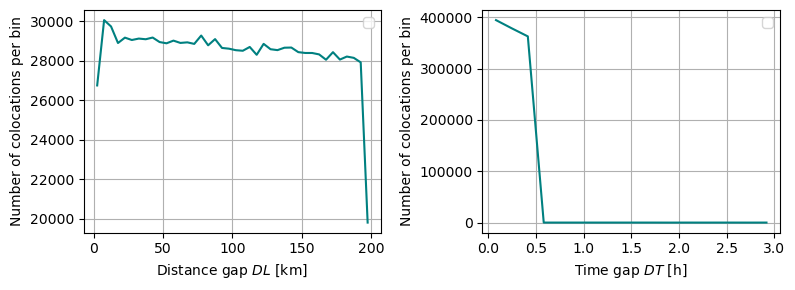

In [6]:
fig, axs = plt.subplots(1,2, figsize=(8,3))
ax = axs[0]
dsd.nb_coloc_bin.plot(ax=ax, c='teal')
ax.legend()
ax.grid()
ax.set_xlabel(r'Distance gap $DL$ [km]')
ax.set_ylabel('Number of colocations per bin')

ax = axs[1]
dst.nb_coloc_bin.plot(ax=ax, c='teal')
ax.legend()
ax.grid()
ax.set_xlabel(r'Time gap $DT$ [h]')
ax.set_ylabel('Number of colocations per bin')
fig.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


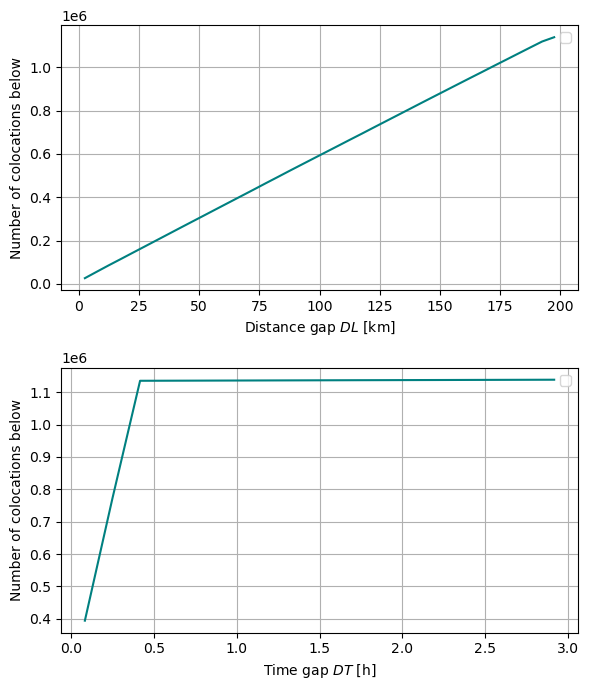

In [7]:
fig, axs = plt.subplots(2,1, figsize=(6,7))
ax = axs[0]
dsd.nb_coloc_bin.cumsum('distbin').plot(ax=ax, c='teal')
ax.legend()
ax.grid()
ax.set_xlabel(r'Distance gap $DL$ [km]')
ax.set_ylabel('Number of colocations below')

ax = axs[1]
dst.nb_coloc_bin.cumsum('timebin').plot(ax=ax, c='teal')
ax.legend()
ax.grid()
ax.set_xlabel(r'Time gap $DT$ [h]')
ax.set_ylabel('Number of colocations below')
fig.tight_layout()

______________________
# Closure efficiancy : $\langle S^2 \rangle$ and $RSE = \frac{\langle S^2 \rangle}{\sum_i \langle x_i^2 \rangle}$
- AVISO more efficient

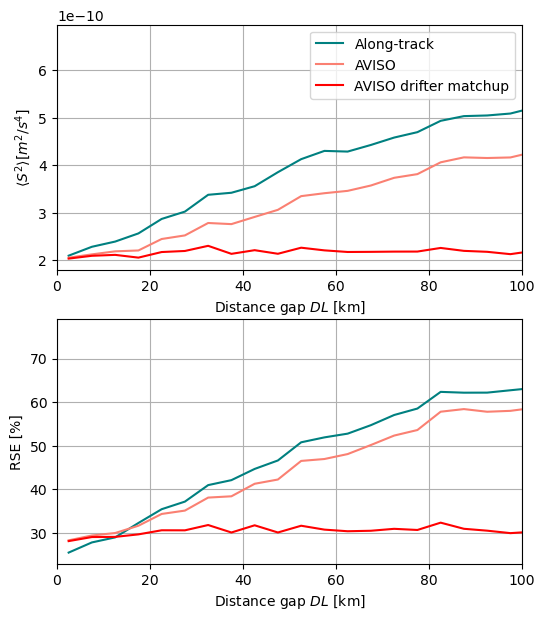

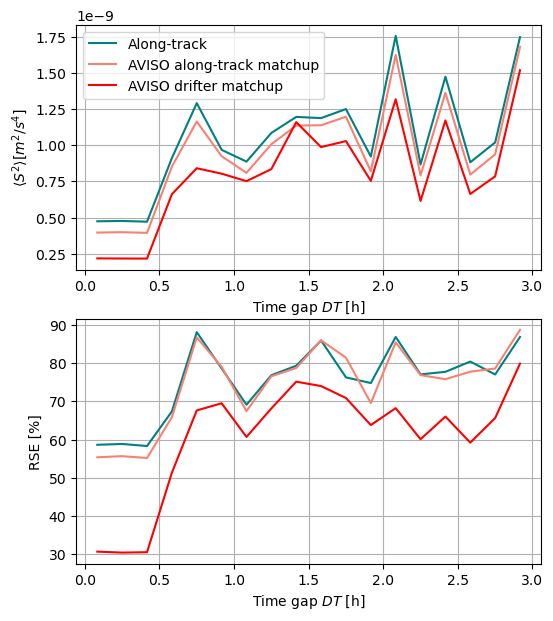

In [8]:
def compute_sum_ms(ds, id_, dic=None):
    if dic == None :
        dic = ds['sum_'+id_].attrs
    return ds[dic['acc']]+ds[dic['coriolis']]+ds[dic['ggrad']]+ds[dic['wind']]
    
fig, axs = plt.subplots(2,1, figsize=(6,7))
ax = axs[0]
dsd['sum_'+id_co].plot(label='Along-track', ax=ax, c='teal')
dsd['sum_'+id_aviso].plot(label='AVISO', ax=ax, c='salmon')
dsd['sum_'+id_aviso_drifter].plot(label='AVISO drifter matchup', ax=ax, c='red')
ax.grid()
ax.legend()
ax.set_xlabel(r'Distance gap $DL$ [km]')
ax.set_ylabel(r'$\langle S^2 \rangle [m^2/s^4]$')
ax.set_xlim(0,100)

ax = axs[1]
(dsd['sum_'+id_co]/compute_sum_ms(dsd, id_co, id_co_dic)*100).plot(label='Along-track', ax=ax, c='teal')
(dsd['sum_'+id_aviso]/compute_sum_ms(dsd, id_aviso, id_aviso_dic)*100).plot(label='AVISO', ax=ax, c='salmon')
(dsd['sum_'+id_aviso_drifter]/compute_sum_ms(dsd, id_aviso_drifter, id_aviso_drifter_dic)*100).plot(label='AVISO drifter matchup', ax=ax, c='red')
ax.set_xlabel(r'Distance gap $DL$ [km]')
ax.set_ylabel('RSE [%]')
ax.grid()
ax.set_xlim(0,100)

fig, axs = plt.subplots(2,1, figsize=(6,7))
ax = axs[0]
dst['sum_'+id_co].plot(label='Along-track', ax=ax, c='teal')
dst['sum_'+id_aviso].plot(label='AVISO along-track matchup', ax=ax, c='salmon')
dst['sum_'+id_aviso_drifter].plot(label='AVISO drifter matchup', ax=ax, c='red')
ax.grid()
ax.legend()
ax.set_xlabel(r'Time gap $DT$ [h]')
ax.set_ylabel(r'$\langle S^2 \rangle [m^2/s^4]$')


ax = axs[1]
(dst['sum_'+id_co]/compute_sum_ms(dst, id_co, id_co_dic)*100).plot(label='Along-track', ax=ax, c='teal')
(dst['sum_'+id_aviso]/compute_sum_ms(dst, id_aviso, id_aviso_dic)*100).plot(label='AVISO', ax=ax, c='salmon')
(dst['sum_'+id_aviso_drifter]/compute_sum_ms(dst, id_aviso_drifter, id_aviso_drifter_dic)*100).plot(label='AVISO drifter matchup', ax=ax, c='red')
#dsd['sum_'+id_aviso].plot(label='AVISO', ax=ax)
ax.set_xlabel(r'Time gap $DT$ [h]')
ax.set_ylabel('RSE [%]')
ax.grid()


______________________
# $x$ contribution : $C_{x_i} =\langle S_{-x_i}^2\rangle-\langle S^2 \rangle$  and $Rcn_{x_i} = \frac{\langle S_{-x_i}^2\rangle-\langle S^2 \rangle}{\sum_i \langle x_i^2 \rangle}$
## Under H1 :
$Rc_{x_i} = \frac{\langle \hat{x}^2 \rangle - \langle {x_i^{e}}^2\rangle}{\sum_i \langle x_i^2 \rangle}$  

 - $RC_{x_i}<0 \Leftrightarrow \langle \hat{x}^2 \rangle < \langle {x_i^{e}}^2\rangle$ more error than signal is added
 - $RC_{x_i}>0 \Leftrightarrow \langle \hat{x}^2 \rangle > \langle {x_i^{e}}^2\rangle$ more signal than error is added
 - The bigger $Rc_x$ is, the better closure we have
Results :
 - $RC_x$<0 for inertial acceleration and wind

In [9]:
def RC_x(ds, id_, dic=None):
    if isinstance(id_, str):
        lab = ['acc', 'coriolis', 'ggrad', 'wind']
        Rc_x = xr.Dataset()
        for l in lab :
            Rc_x[l] = (ds['exc_'+l+'_'+id_] - ds['sum_'+id_])
    return Rc_x
    
def RCn_x(ds, id_, dic=None):
    if isinstance(id_, str):
        lab = ['acc', 'coriolis', 'ggrad', 'wind']
        s = compute_sum_ms(ds, id_, dic)
        Rcn_x = xr.Dataset()
        for l in lab :
            Rcn_x[l] = (ds['exc_'+l+'_'+id_] - ds['sum_'+id_])/s
    return Rcn_x
    
RCXnd = xr.concat([RCn_x(dsd, id_co, dic = id_co_dic), RCn_x(dsd, id_aviso, dic = id_aviso_dic)], dim =pd.Index([id_co, id_aviso], name='id_comb')) 
RCXnt = xr.concat([RCn_x(dst, id_co, dic = id_co_dic), RCn_x(dst, id_aviso, dic = id_aviso_dic)], dim =pd.Index([id_co, id_aviso], name='id_comb'))

RCXd = xr.concat([RC_x(dsd, id_co, dic = id_co_dic), RC_x(dsd, id_aviso, dic = id_aviso_dic)], dim =pd.Index([id_co, id_aviso], name='id_comb')) 
RCXt = xr.concat([RC_x(dst, id_co, dic = id_co_dic), RC_x(dst, id_aviso, dic = id_aviso_dic)], dim =pd.Index([id_co, id_aviso], name='id_comb')) 

Text(0.5, 1.0, '')

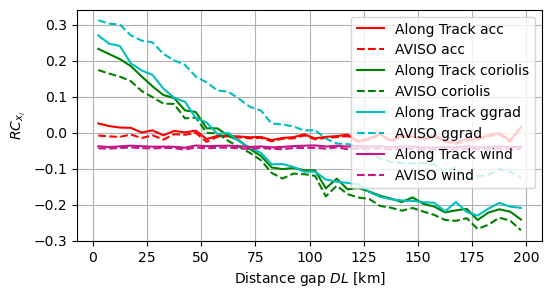

In [11]:

plt.figure(figsize=(6,3))
for v in ['acc', 'coriolis', 'ggrad', 'wind']:
    RCXnd.sel(id_comb=id_co)[v].plot(label='Along Track ' +v, color = term_color[v])
    RCXnd.sel(id_comb=id_aviso)[v].plot(label='AVISO ' +v, color = term_color[v], ls='--')
plt.legend()
plt.grid()
plt.xlabel(r'Distance gap $DL$ [km]')
plt.ylabel(r'$RC_{x_i}$')
plt.title('')


Text(0.5, 1.0, '')

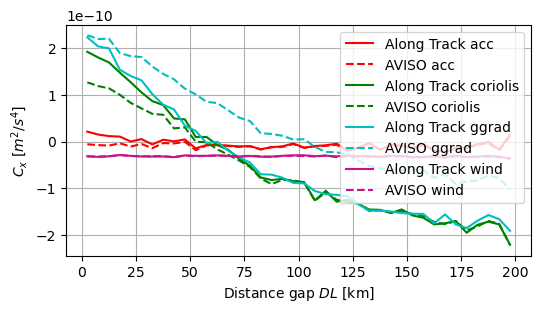

In [27]:

plt.figure(figsize=(6,3))
for v in ['acc', 'coriolis', 'ggrad', 'wind']:
    RCXd.sel(id_comb=id_co)[v].plot(label='Along Track ' +v, color = term_color[v])
    RCXd.sel(id_comb=id_aviso)[v].plot(label='AVISO ' +v, color = term_color[v], ls='--')
plt.legend()
plt.grid()
plt.xlabel(r'Distance gap $DL$ [km]')
plt.ylabel(r'$C_{x}$ $[m^2/s^4]$')
plt.title('')


Text(0, 0.5, '$RC_x$')

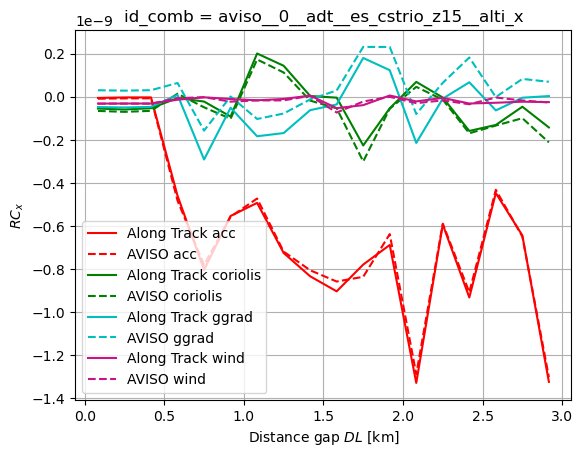

In [13]:
for v in ['acc', 'coriolis', 'ggrad', 'wind']:
    RCXt.sel(id_comb=id_co)[v].plot(label='Along Track ' +v, color = term_color[v])
    RCXt.sel(id_comb=id_aviso)[v].plot(label='AVISO ' +v, color = term_color[v], ls='--')
plt.legend()
plt.grid()
plt.xlabel(r'Distance gap $DL$ [km]')
plt.ylabel(r'$RC_x$')

________________________
# True/Error in $x$ 
$\langle \hat{x_i} \rangle +\langle \hat{x_i}{x_i^{e}}^2 \rangle  = \frac{1}{2}(\langle x_i^2 \rangle - \langle S^2 \rangle +\langle S_{-x_i}^2 \rangle) $  

$\langle {x_i^{e}}^2 \rangle+\langle \hat{x_i}{x_i^{e}}^2 \rangle  = \frac{1}{2}(\langle x_i^2 \rangle + \langle S^2 \rangle -\langle S_{-x_i}^2 \rangle) $
## Under H1

$\langle \hat{x_i} \rangle  = \frac{1}{2}(\langle x_i^2 \rangle - \langle S^2 \rangle +\langle S_{-x_i}^2 \rangle) $  

$\langle {x_i^{e}}^2 \rangle  = \frac{1}{2}(\langle x_i^2 \rangle + \langle S^2 \rangle -\langle S_{-x_i}^2 \rangle) $

In [18]:
def true_err_x(ds, id_, dic) :
    dso = xr.Dataset()
    dso['S'] = ds_['sum_'+id_]
    for x in ['acc', 'coriolis', 'ggrad', 'wind']:
        X =dic[x]
        dso[x] = ds_[X]
        dso['exc_'+x] = ds_['exc_' + x +'_'+ id_]
        dso['true_'+x] = (ds_[X] - ds_['sum_'+id_] + ds_['exc_' + x +'_'+ id_])/2
        dso['err_'+x] = (ds_[X] + ds_['sum_'+id_] - ds_['exc_' + x +'_'+ id_])/2
        
    dso['sum_x']=dso['acc']+dso['coriolis']+dso['ggrad']+dso['wind']
    dso['sum_truex']=dso['true_acc']+dso['true_coriolis']+dso['true_ggrad']+dso['true_wind']
    dso['sum_errx']=dso['err_acc']+dso['err_coriolis']+dso['err_ggrad']+dso['err_wind']
    return dso
    
dsdt = xr.concat([true_err_x(dsd, id_co, id_co_dic), true_err_x(dsd, id_aviso, id_aviso_dic)], dim=pd.Index([id_co, id_aviso], name = 'id_comb'))
dstt = xr.concat([true_err_x(dst, id_co, id_co_dic), true_err_x(dst, id_aviso, id_aviso_dic)], dim=pd.Index([id_co, id_aviso], name = 'id_comb'))

In [19]:
dsdt

<xarray.Dataset>
Dimensions:        (distbin: 40, id_comb: 2)
Coordinates:
  * distbin        (distbin) float64 2.5 7.5 12.5 17.5 ... 187.5 192.5 197.5
  * id_comb        (id_comb) object 'co__0__adt_filtered__es_cstrio_z15__drif...
Data variables: (12/20)
    S              (id_comb, distbin) float64 2.099e-10 2.286e-10 ... 5.818e-10
    acc            (id_comb, distbin) float64 1.42e-10 1.424e-10 ... 1.467e-10
    exc_acc        (id_comb, distbin) float64 2.309e-10 2.434e-10 ... 5.937e-10
    true_acc       (id_comb, distbin) float64 8.153e-11 7.863e-11 ... 7.929e-11
    err_acc        (id_comb, distbin) float64 6.047e-11 6.379e-11 ... 6.737e-11
    coriolis       (id_comb, distbin) float64 3.746e-10 3.735e-10 ... 4.355e-10
    ...             ...
    exc_wind       (id_comb, distbin) float64 1.785e-10 1.956e-10 ... 5.449e-10
    true_wind      (id_comb, distbin) float64 -6.437e-12 ... -7.373e-12
    err_wind       (id_comb, distbin) float64 2.49e-11 2.577e-11 ... 2.945e-11
    sum_x          (id_comb, distbin) float64 8.229e-10 8.212e-10 ... 8.157e-10
    sum_truex      (id_comb, distbin) float64 6.131e-10 5.926e-10 ... 2.339e-10
    sum_errx       (id_comb, distbin) float64 2.099e-10 2.286e-10 ... 5.818e-10

Text(0.5, 1.0, '')

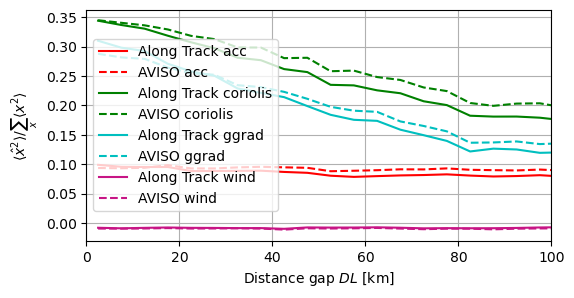

In [20]:
plt.figure(figsize=(6,3))
for v in ['acc', 'coriolis', 'ggrad', 'wind']:
    (dsdt.sel(id_comb=id_co)['true_'+v]/dsdt.sel(id_comb=id_co)['sum_x']).plot(label='Along Track ' +v, color = term_color[v])
    (dsdt.sel(id_comb=id_aviso)['true_'+v]/dsdt.sel(id_comb=id_aviso)['sum_x']).plot(label='AVISO ' +v, color = term_color[v], ls='--')
plt.legend()
plt.grid()
plt.xlim(0,100)
plt.xlabel(r'Distance gap $DL$ [km]')
plt.ylabel(r'$\langle \hat{x}^2 \rangle / \sum_x{\langle x^2 \rangle} $')
plt.title('')

Text(0.5, 1.0, '')

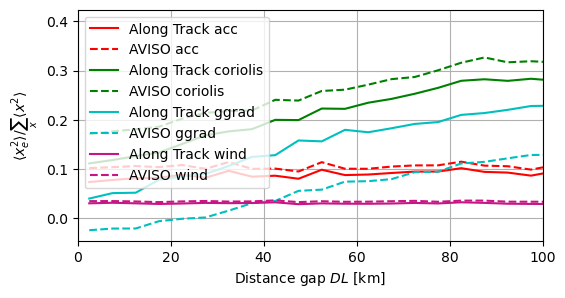

In [21]:
plt.figure(figsize=(6,3))
for v in ['acc', 'coriolis', 'ggrad', 'wind']:
    (dsdt.sel(id_comb=id_co)['err_'+v]/dsdt.sel(id_comb=id_co)['sum_x']).plot(label='Along Track ' +v, color = term_color[v])
    (dsdt.sel(id_comb=id_aviso)['err_'+v]/dsdt.sel(id_comb=id_aviso)['sum_x']).plot(label='AVISO ' +v, color = term_color[v], ls='--')
plt.legend()
plt.grid()
plt.xlim(0,100)
plt.xlabel(r'Distance gap $DL$ [km]')
plt.ylabel(r'$\langle x_e^2 \rangle / \sum_x{\langle x^2 \rangle} $')
plt.title('')

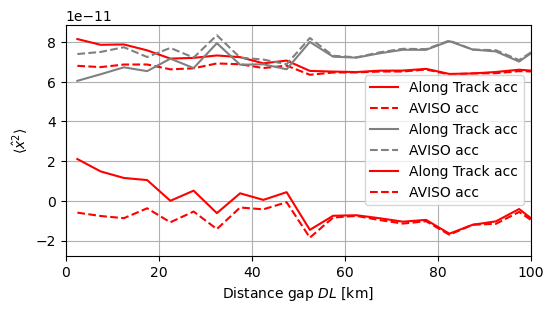

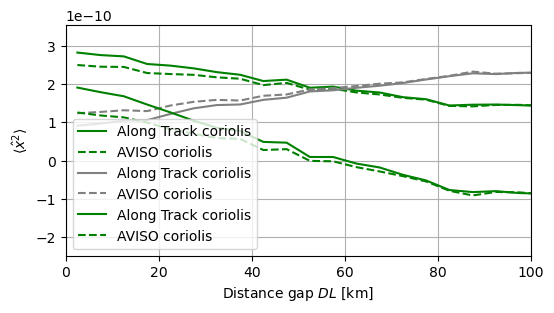

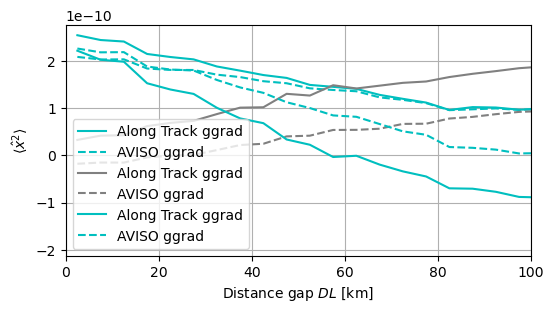

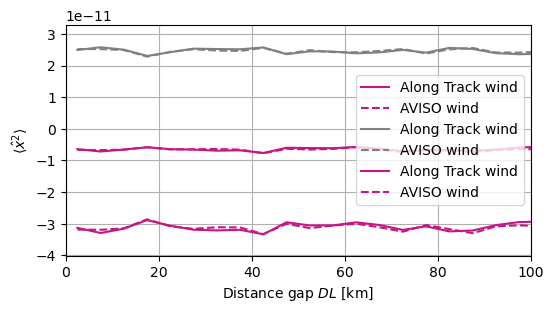

In [24]:
for v in ['acc', 'coriolis', 'ggrad', 'wind']:
    plt.figure(figsize=(6,3))
    (dsdt.sel(id_comb=id_co)['true_'+v]).plot(label='Along Track ' +v, color = term_color[v])
    (dsdt.sel(id_comb=id_aviso)['true_'+v]).plot(label='AVISO ' +v, color = term_color[v], ls='--')
    (dsdt.sel(id_comb=id_co)['err_'+v]).plot(label='Along Track ' +v, color = 'grey')
    (dsdt.sel(id_comb=id_aviso)['err_'+v]).plot(label='AVISO ' +v, color ='grey', ls='--')
    RCXd.sel(id_comb=id_co)[v].plot(label='Along Track ' +v, color = term_color[v])
    RCXd.sel(id_comb=id_aviso)[v].plot(label='AVISO ' +v, color = term_color[v], ls='--')
    plt.legend()
    plt.grid()
    plt.xlim(0,100)
    plt.xlabel(r'Distance gap $DL$ [km]')
    plt.ylabel(r'$\langle \hat{x}^2 \rangle $')
    plt.title('')

Text(0.5, 1.0, '')

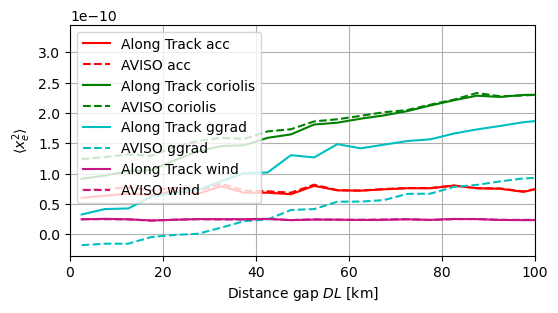

In [25]:
plt.figure(figsize=(6,3))
for v in ['acc', 'coriolis', 'ggrad', 'wind']:
    (dsdt.sel(id_comb=id_co)['err_'+v]).plot(label='Along Track ' +v, color = term_color[v])
    (dsdt.sel(id_comb=id_aviso)['err_'+v]).plot(label='AVISO ' +v, color = term_color[v], ls='--')
plt.legend()
plt.grid()
plt.xlim(0,100)
plt.xlabel(r'Distance gap $DL$ [km]')
plt.ylabel(r'$\langle x_e^2 \rangle $')
plt.title('')

Text(0.5, 1.0, '')

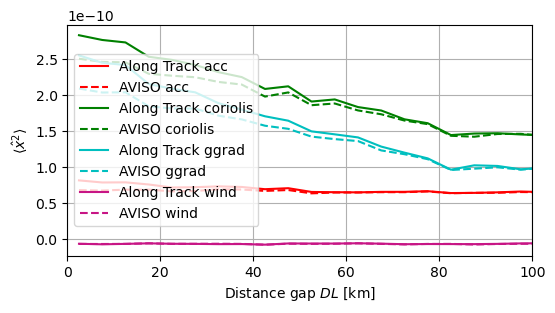

In [26]:
plt.figure(figsize=(6,3))
for v in ['acc', 'coriolis', 'ggrad', 'wind']:
    (dsdt.sel(id_comb=id_co)['true_'+v]).plot(label='Along Track ' +v, color = term_color[v])
    (dsdt.sel(id_comb=id_aviso)['true_'+v]).plot(label='AVISO ' +v, color = term_color[v], ls='--')
plt.legend()
plt.grid()
plt.xlim(0,100)
plt.xlabel(r'Distance gap $DL$ [km]')
plt.ylabel(r'$\langle \hat{x}^2 \rangle $')
plt.title('')